In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)				

In [70]:
import pandas as pd

def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

df_train = pd.read_csv('D:\\downloads\\DATASET-DATASCIENCE-20211015T124508Z-001\\Basic Feature Discovering for Machine Learning\\titanic_train.csv')
df_test = pd.read_csv('D:\\downloads\\DATASET-DATASCIENCE-20211015T124508Z-001\\Basic Feature Discovering for Machine Learning\\titanic_test.csv')
df_all = concat_df(df_train, df_test)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set' 

dfs = [df_train, df_test]

In [71]:
#exploring data
print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['Survived'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)

Number of Training Examples = 891
Number of Test Examples = 418

Training X Shape = (891, 12)
Training y Shape = 891

Test X Shape = (418, 11)
Test y Shape = 418

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [72]:
#missing value dan contoh data
df_train.info(memory_usage=False)
print(df_train.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7  

<AxesSubplot:>

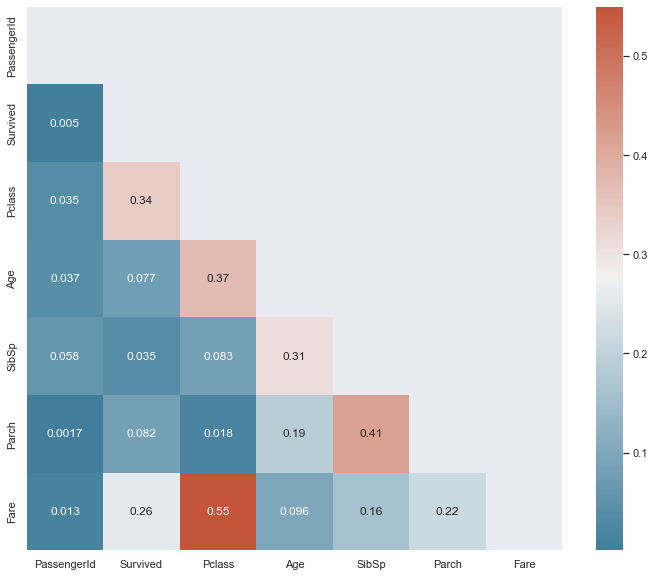

In [73]:
#mengetahui korelasi fitur menggunakan seaborn dan pyplot
df_train_corr = df_train.corr().abs()
f, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(df_train_corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(df_train_corr, annot=True, mask = mask, cmap=cmap)

In [74]:
#mengenal missing value dari kolom
def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')

for df in dfs:
    print('{}'.format(df.name))
    display_missing(df)

Training Set
PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2


Test Set
PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 86
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 327
Embarked column missing values: 0




In [75]:
#mencari nilai untuk missing value
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass']).median()['Age']

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))
print('Median age of all passengers: {}'.format(df_all['Age'].median()))

# Filling the missing values in Age with the medians of Sex and Pclass groups
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

Median age of Pclass 1 females: 36.0
Median age of Pclass 1 males: 42.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.5
Median age of Pclass 3 females: 22.0
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0


In [76]:
# Filling the missing values in Embarked with S
df_all['Embarked'] = df_all['Embarked'].fillna('S')
med_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
# Filling the missing value in Fare with the median Fare of 3rd class alone passenger
df_all['Fare'] = df_all['Fare'].fillna(med_fare)

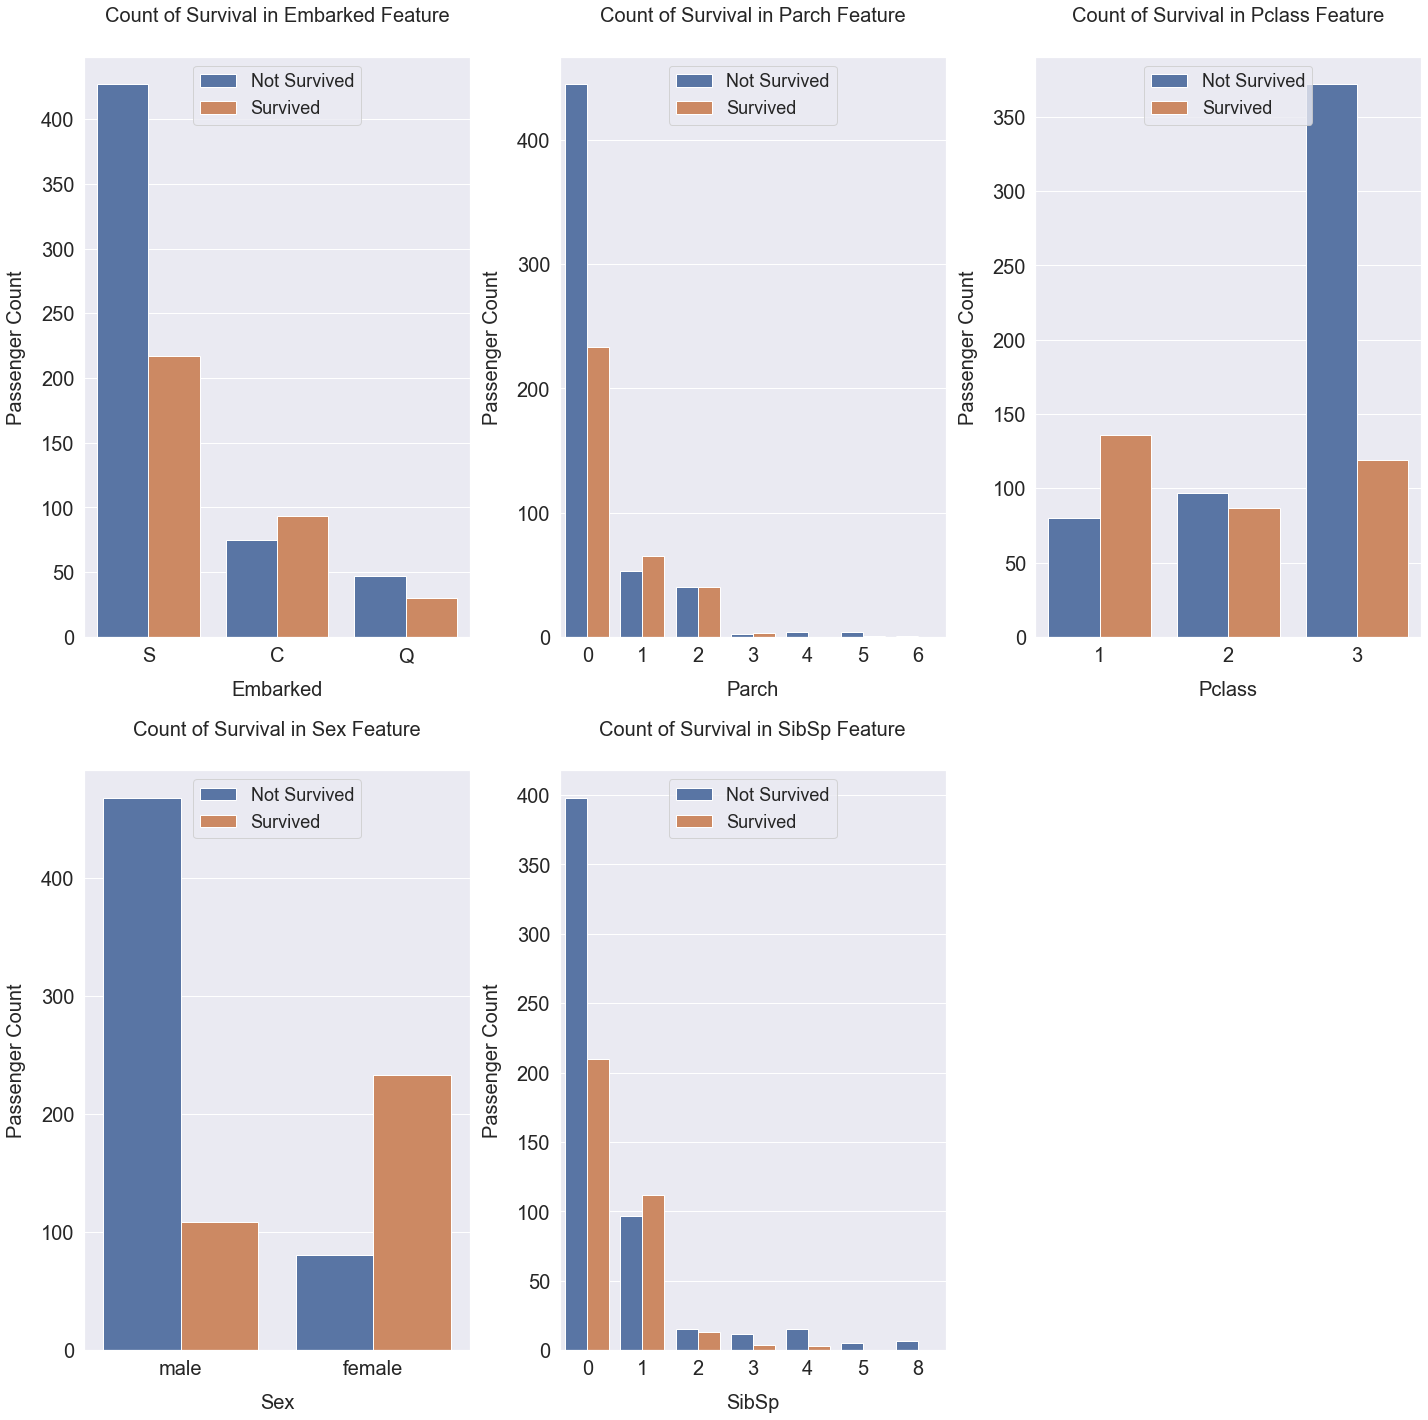

In [56]:
#exploring data
cat_features = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp']

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_features, 1):    
    plt.subplot(2, 3, i)
    sns.countplot(x=feature, hue='Survived', data=df_train)
    
    plt.xlabel('{}'.format(feature), size=20, labelpad=15)
    plt.ylabel('Passenger Count', size=20, labelpad=15)    
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    
    plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size': 18})
    plt.title('Count of Survival in {} Feature'.format(feature), size=20, y=1.05)

plt.tight_layout()
plt.show()

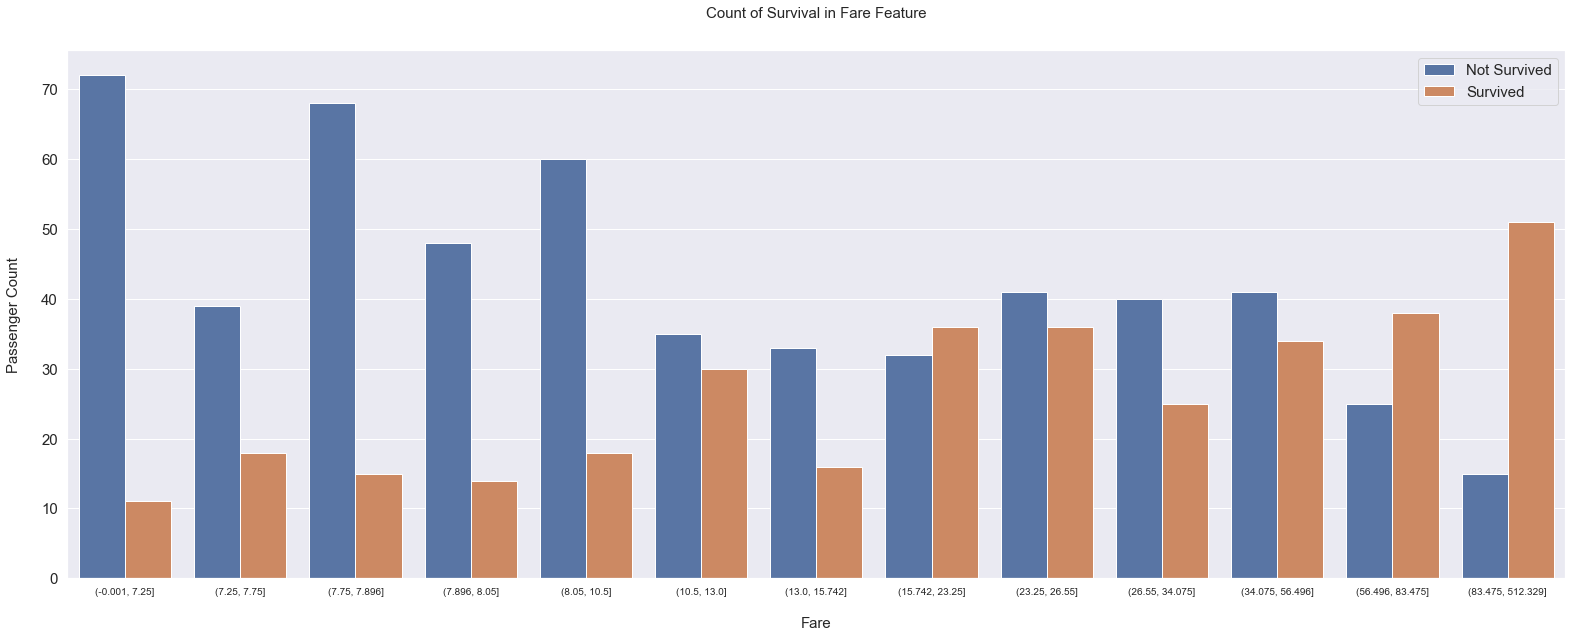

In [57]:
df_all['Fare'] = pd.qcut(df_all['Fare'], 13)

fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Fare', hue='Survived', data=df_all)

plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Fare'), size=15, y=1.05)
plt.tight_layout()
plt.show()

Fitur Engineering

Fitur pertama yang kita buat adalah Family_Size, sesuai namanya ini adalah gabungan dari Parent, Children, Sibling, dan Spouse. Lalu kita tambahkan 1 dengan asumsi menghitung diri orang itu juga.

Fitur kedua yang kita buat adalah menggabungkan Family_Size dengan groupnya masing-masing tergantung jumlahnya.
Kategorinya adalah seperti berikut.

    Family Size 1 = Alone
    Family Size 2, 3 dan 4 = Small
    Family Size 5 dan 6 = Medium
    Family Size 7, 8 dan 11 = Large


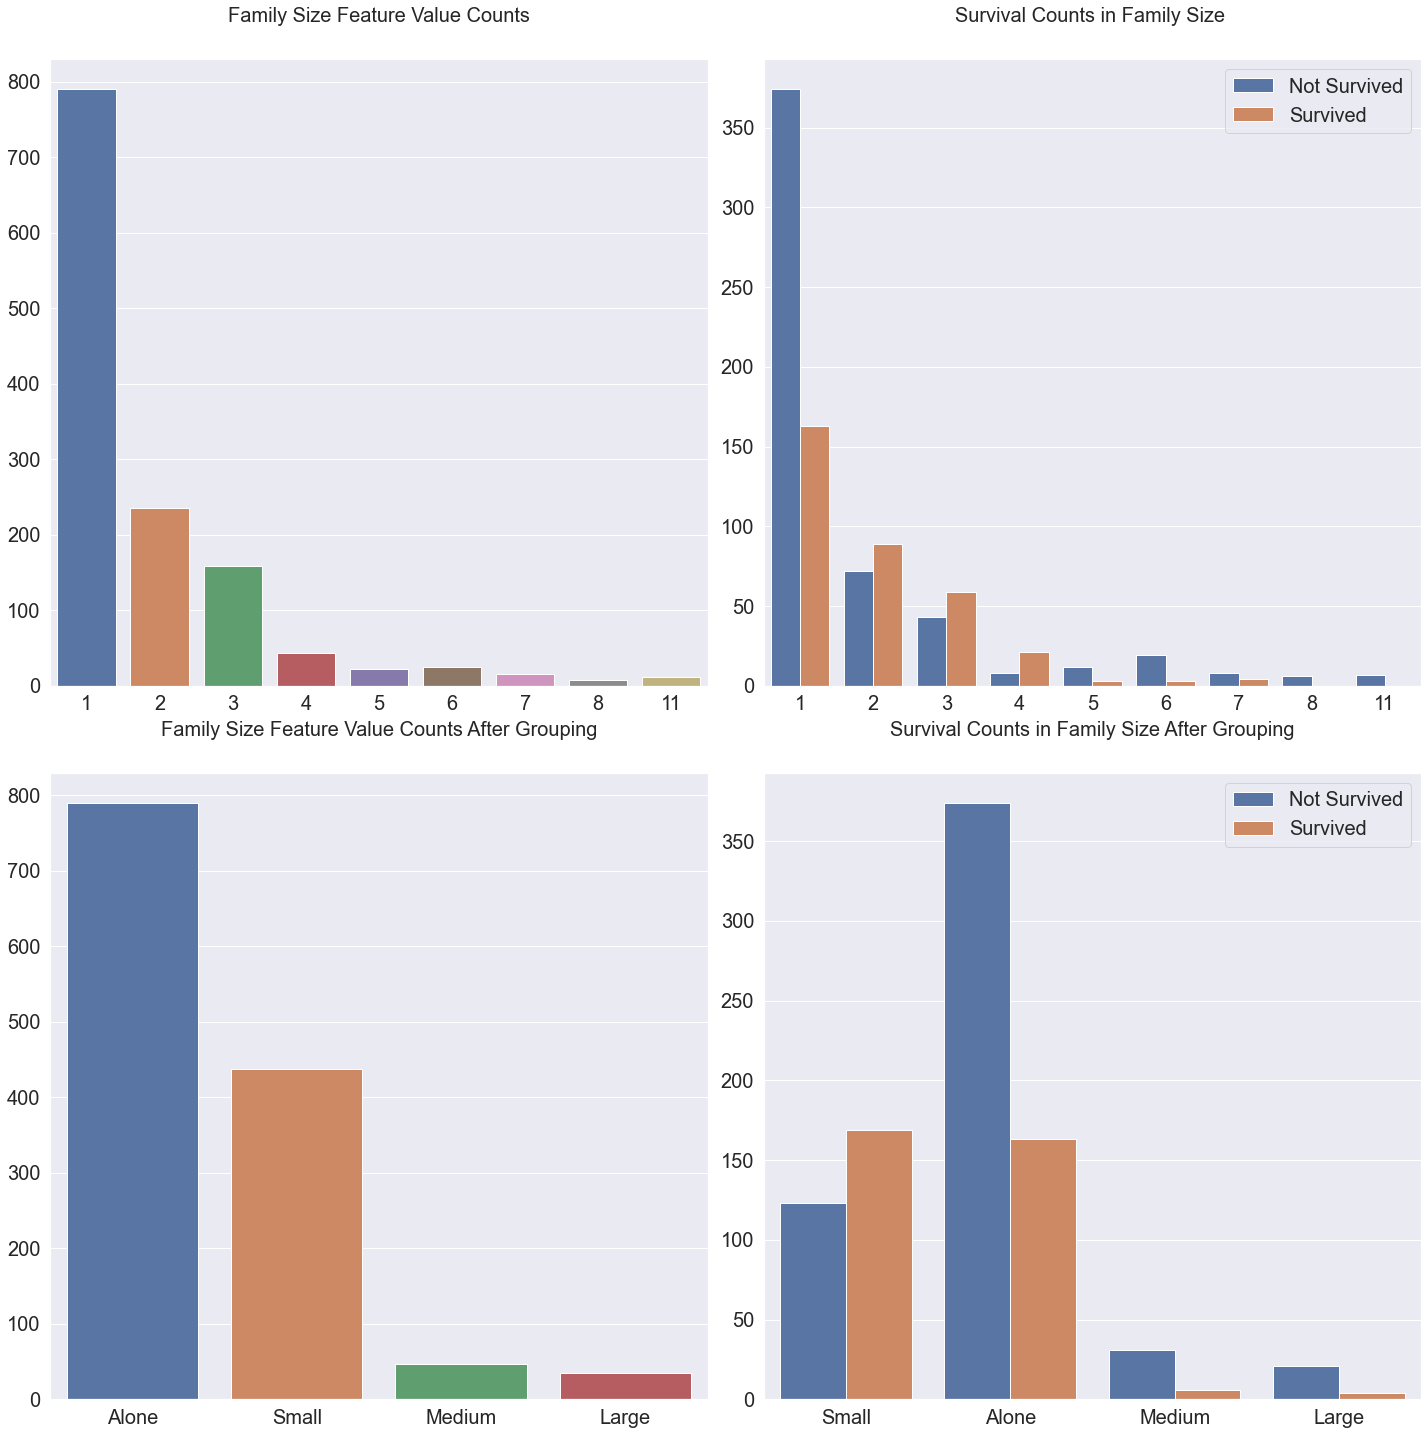

In [58]:
#feature engineering
df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] + 1

fig, axs = plt.subplots(figsize=(20, 20), ncols=2, nrows=2)
plt.subplots_adjust(right=1.5)

sns.barplot(x=df_all['Family_Size'].value_counts().index, y=df_all['Family_Size'].value_counts().values, ax=axs[0][0])
sns.countplot(x='Family_Size', hue='Survived', data=df_all, ax=axs[0][1])

axs[0][0].set_title('Family Size Feature Value Counts', size=20, y=1.05)
axs[0][1].set_title('Survival Counts in Family Size ', size=20, y=1.05)

family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df_all['Family_Size_Grouped'] = df_all['Family_Size'].map(family_map)

sns.barplot(x=df_all['Family_Size_Grouped'].value_counts().index, y=df_all['Family_Size_Grouped'].value_counts().values, ax=axs[1][0])
sns.countplot(x='Family_Size_Grouped', hue='Survived', data=df_all, ax=axs[1][1])

axs[1][0].set_title('Family Size Feature Value Counts After Grouping', size=20, y=1.05)
axs[1][1].set_title('Survival Counts in Family Size After Grouping', size=20, y=1.05)

for i in range(2):
    axs[i][1].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')
plt.tight_layout()
plt.show()

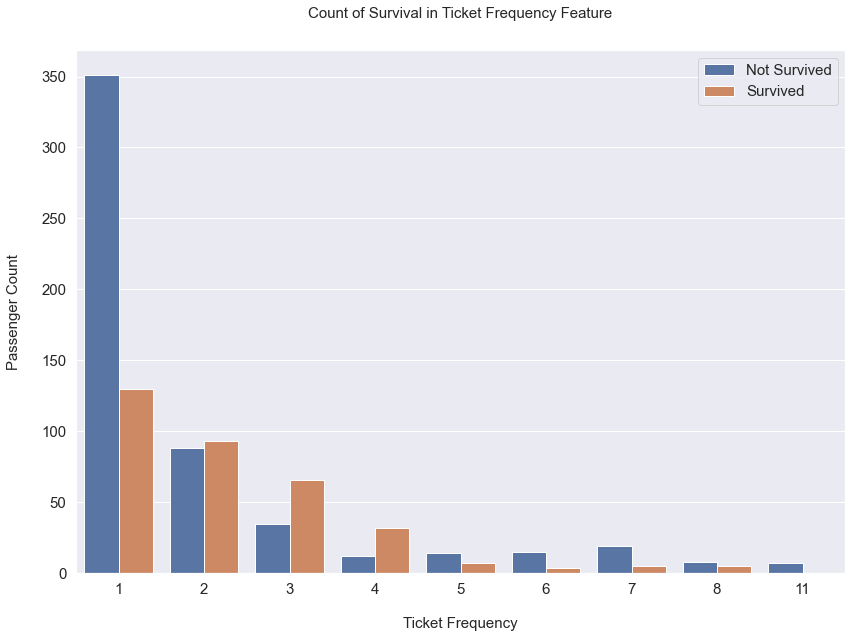

In [59]:
family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df_all['Family_Size_Grouped'] = df_all['Family_Size'].map(family_map)

df_all['Ticket_Frequency'] = df_all.groupby('Ticket')['Ticket'].transform('count')

fig, axs = plt.subplots(figsize=(12, 9))
sns.countplot(x='Ticket_Frequency', hue='Survived', data=df_all)

plt.xlabel('Ticket Frequency', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Ticket Frequency'), size=15, y=1.05)
plt.tight_layout()
plt.show()

In [60]:
df_all['Title'] = df_all['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]

print(df_all['Title'].unique())

df_all['Is_Married'] = 0
df_all['Is_Married'].loc[df_all['Title'] == 'Mrs'] = 1

print(df_all['Title'].unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer' 'Dona']
['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer' 'Dona']


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


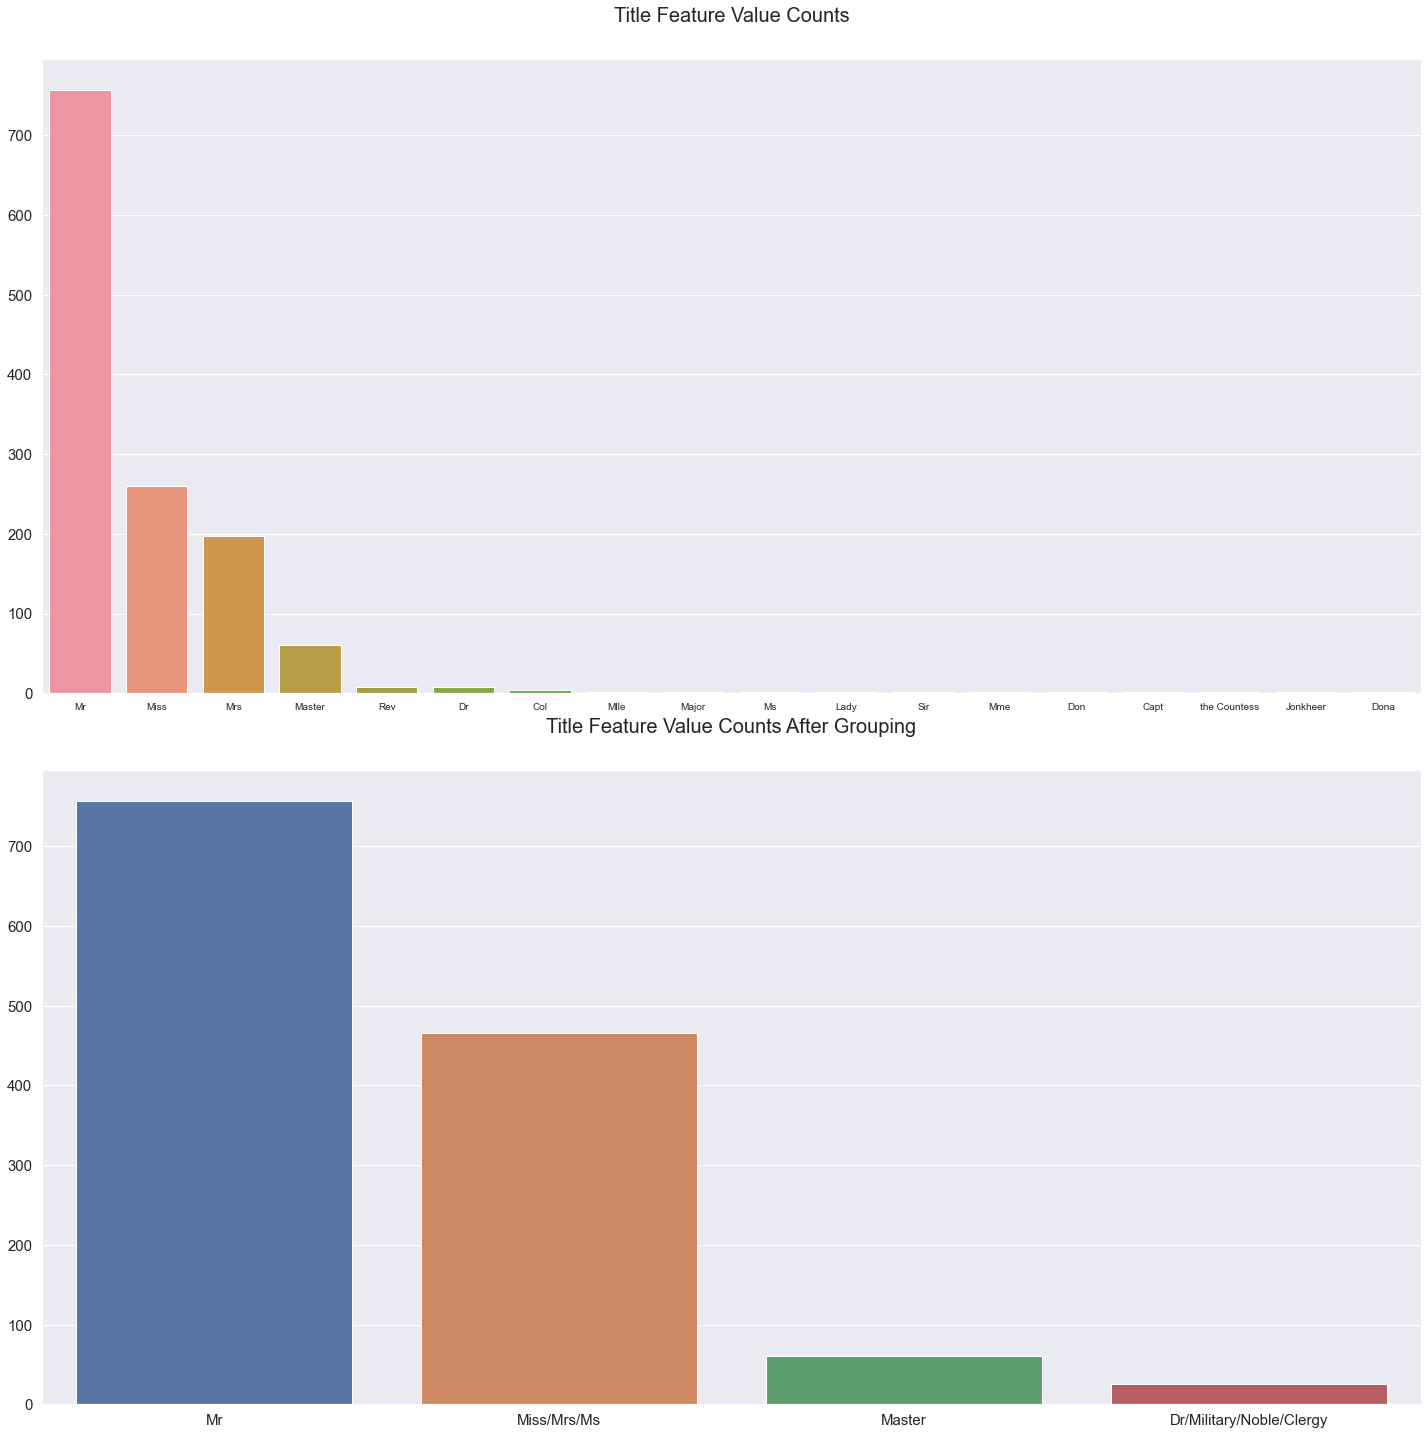

In [61]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))
sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[0])

axs[0].tick_params(axis='x', labelsize=10)
axs[1].tick_params(axis='x', labelsize=15)

for i in range(2):    
    axs[i].tick_params(axis='y', labelsize=15)

axs[0].set_title('Title Feature Value Counts', size=20, y=1.05)

df_all['Title'] = df_all['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
df_all['Title'] = df_all['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[1])
axs[1].set_title('Title Feature Value Counts After Grouping', size=20, y=1.05)
plt.tight_layout()
plt.show()

In [62]:
df_all.head(5)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family_Size,Family_Size_Grouped,Ticket_Frequency,Title,Is_Married
0,22.0,NaN,S,"(-0.001, 7.25]","Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,2,Small,1,Mr,0
1,38.0,C85,C,"(56.496, 83.475]","Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,2,Small,2,Miss/Mrs/Ms,1
2,26.0,NaN,S,"(7.896, 8.05]","Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,1,Alone,1,Miss/Mrs/Ms,0
3,35.0,C123,S,"(34.075, 56.496]","Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,2,Small,2,Miss/Mrs/Ms,1
4,35.0,NaN,S,"(7.896, 8.05]","Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,1,Alone,1,Mr,0


In [63]:
#Modelling dengan hasil Feature Engineering
df_train = df_all.loc[:890]
df_test = df_all.loc[891:]
dfs = [df_train, df_test]

non_numeric_features = ['Embarked', 'Sex', 'Title', 'Family_Size_Grouped', 'Age', 'Fare']

for df in dfs:
    for feature in non_numeric_features:        
        df[feature] = LabelEncoder().fit_transform(df[feature])
        
cat_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'Family_Size_Grouped']
encoded_features = []

for df in dfs:
    for feature in cat_features:
        encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)

df_train = pd.concat([df_train, *encoded_features[:5]], axis=1)
df_test = pd.concat([df_test, *encoded_features[5:]], axis=1)

C:\Users\User\AppData\Local\Temp/ipykernel_7536/2616788297.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = LabelEncoder().fit_transform(df[feature])


In [64]:
df_all = concat_df(df_train, df_test)
drop_cols = ['Cabin', 'Embarked', 'Family_Size', 'Family_Size_Grouped', 'Survived',
'Name', 'PassengerId', 'Pclass', 'Sex', 'Ticket', 'Title']
df_all.drop(columns=drop_cols, inplace=True)
print(df_all.head())

   Age  Embarked_1  Embarked_2  Embarked_3  Family_Size_Grouped_1  \
0   28         0.0         0.0         1.0                    0.0   
1   52         1.0         0.0         0.0                    0.0   
2   34         0.0         0.0         1.0                    1.0   
3   48         0.0         0.0         1.0                    0.0   
4   48         0.0         0.0         1.0                    1.0   

   Family_Size_Grouped_2  Family_Size_Grouped_3  Family_Size_Grouped_4  Fare  \
0                    0.0                    0.0                    1.0     0   
1                    0.0                    0.0                    1.0    11   
2                    0.0                    0.0                    0.0     3   
3                    0.0                    0.0                    1.0    10   
4                    0.0                    0.0                    0.0     3   

   Is_Married  ...  Pclass_2  Pclass_3  Sex_1  Sex_2  SibSp  Ticket_Frequency  \
0           0  ...     

In [65]:
X_train = StandardScaler().fit_transform(df_train.drop(columns=drop_cols))
y_train = df_train['Survived'].values
X_test = StandardScaler().fit_transform(df_test.drop(columns=drop_cols))

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (891, 22)
y_train shape: (891,)
X_test shape: (418, 22)


In [66]:
random_forest = RandomForestClassifier(criterion='gini', 
                                           n_estimators=1100,
                                           max_depth=5,
                                           min_samples_split=4,
                                           min_samples_leaf=5,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=50)
random_forest.fit(X_train, y_train)
from sklearn.model_selection import cross_val_score
scores = cross_val_score(random_forest, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.83333333 0.87640449 0.76404494 0.87640449 0.84269663 0.80898876
 0.82022472 0.78651685 0.87640449 0.85393258]
Mean: 0.8338951310861423
Standard Deviation: 0.03719055862675359


In [67]:
#Modelling tanpa hasil Feature Engineering
df_all = concat_df(df_train, df_test)
drop_cols = ['Cabin', 'Embarked', 'Family_Size', 'Family_Size_Grouped', 'Survived',
             'Name', 'PassengerId', 'Pclass', 'Sex', 'Ticket', 'Title',
             'Family_Size_Grouped_1', 'Family_Size_Grouped_2', 'Family_Size_Grouped_3', 'Family_Size_Grouped_4',
             'Ticket_Frequency', 'Title_1', 'Title_2', 'Title_3', 'Title_4', 'Is_Married']

df_all.drop(columns=drop_cols, inplace=True)

print(df_all.head())

X_train = StandardScaler().fit_transform(df_train.drop(columns=drop_cols))
y_train = df_train['Survived'].values
X_test = StandardScaler().fit_transform(df_test.drop(columns=drop_cols))

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))

   Age  Embarked_1  Embarked_2  Embarked_3  Fare  Parch  Pclass_1  Pclass_2  \
0   28         0.0         0.0         1.0     0      0       0.0       0.0   
1   52         1.0         0.0         0.0    11      0       1.0       0.0   
2   34         0.0         0.0         1.0     3      0       0.0       0.0   
3   48         0.0         0.0         1.0    10      0       1.0       0.0   
4   48         0.0         0.0         1.0     3      0       0.0       0.0   

   Pclass_3  Sex_1  Sex_2  SibSp  
0       1.0    0.0    1.0      1  
1       0.0    1.0    0.0      1  
2       1.0    1.0    0.0      0  
3       0.0    1.0    0.0      1  
4       1.0    0.0    1.0      0  
X_train shape: (891, 12)
y_train shape: (891,)
X_test shape: (418, 12)


In [68]:
random_forest = RandomForestClassifier(criterion='gini', 
                                           n_estimators=1100,
                                           max_depth=5,
                                           min_samples_split=4,
                                           min_samples_leaf=5,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=50)
random_forest.fit(X_train, y_train)
from sklearn.model_selection import cross_val_score
scores = cross_val_score(random_forest, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.78888889 0.84269663 0.76404494 0.87640449 0.85393258 0.80898876
 0.79775281 0.7752809  0.86516854 0.80898876]
Mean: 0.818214731585518
Standard Deviation: 0.03700330937285851


score modelling dengan feature engineering:
> Scores: [0.83333333 0.87640449 0.76404494 0.87640449 0.84269663 0.80898876
 0.82022472 0.78651685 0.87640449 0.85393258]

Mean: 0.8338951310861423
Standard Deviation: 0.03719055862675359

score modelling tanpa feature engineering:
> Scores: [0.78888889 0.84269663 0.76404494 0.87640449 0.85393258 0.80898876
 0.79775281 0.7752809  0.86516854 0.80898876]
 
Mean: 0.818214731585518
Standard Deviation: 0.03700330937285851

dapat disimpulkan bahwa dengan menggunakan feature engineering, score modelling lebih baik